In [28]:
!pip install --upgrade "jax[cuda]==0.3.15" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jaxlib[cuda]==0.3.15" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install ./jaxns
!pip install git+https://github.com/adam-coogan/jaxinterp2d.git
!pip install corner
!pip install healpy
!pip install arviz

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Defaulting to user installation because normal site-packages is not writeable
Processing ./jaxns
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jaxns: filename=jaxns-0.0.7-py3-none-any.whl size=95014 sha256=ef1414c2a76740a95a01c23fdb838aa41b46457c487adab7c9629808c37670a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-telts31b/wheels/9c/7d/d8/5e3476e7cb49b9318aa6190f6a40157f09df1e693aa0b4ea91
Successfully built jaxns
  Attempting uninstall: jaxns
    Found existing installation: jaxns 0.0.7
    Uninstalling jaxns-0.

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99'

In [2]:
import jax

import jaxns
from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns.utils import summary, resample
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGHEST)

In [3]:
import h5py

with h5py.File('standard-sirens32_approx.h5', 'r') as f:
    nside = f.attrs['nside']
    n0fid = f.attrs['n0fid']
    H0Planck = f.attrs['H0fid']
    zgrid = jnp.asarray(f['zgrid'])
    Om0grid = jnp.asarray(f['Om0grid'])
    deltagrid = jnp.asarray(f['deltagrid'])
    fs = jnp.asarray(f['fs'])
    vals = jnp.asarray(f['pcat'])

print(zgrid.shape, Om0grid.shape, deltagrid.shape)
print(fs.shape, vals.shape)

(1000,) (50,) (50,)
(12288, 50, 50) (12288, 1000)


In [4]:
from jaxinterp2d import interp2d, CartesianGrid

Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 278.12it/s]


In [5]:
GWTC1=False

if GWTC1:
    def get_posdict(BBHevents,samples_path_template,nsamp=None):
        """
        load samples in GWTC-1 data release format into a dictionary
        """
        posdict = {}
        dLs = []
        ras = []
        decs = []
        m1dets = []
        m2dets = []
        
        for BBH in BBHevents:
            print(BBH)
            if BBH in GWTC1:
                samples_path = samples_path_template.format(BBH)
                with h5py.File(samples_path,'r') as f:
                    if nsamp is not None:
                        pos = np.random.choice(f['Overall_posterior'][...],size=nsamp,replace=False)
                    else:
                        pos = f['Overall_posterior'][...]
                    dL = pos['luminosity_distance_Mpc']
                    m1det = pos['m1_detector_frame_Msun']
                    m2det = pos['m2_detector_frame_Msun']
                    q = m2det/m1det
                    # undo redshifting of masses in detector frame flat mass prior 
                    prior = dL**2
                    dLs.append(dL)
                    m1dets.append(m1det)
                    m2dets.append(m2det)
                    ras.append(pos['right_ascension'])
                    decs.append(pos['declination'])

        posdict['m1det'] = np.concatenate(m1dets)
        posdict['m2det'] = np.concatenate(m2dets)
        posdict['dL'] = (np.concatenate(dLs)*u.Mpc).value
        posdict['ra'] = np.concatenate(ras)
        posdict['dec'] = np.concatenate(decs)
        posdict['nsamples'] = nsamp
        return posdict

    # get the samples
    samples_path_template = '/content/drive/MyDrive/GWTC-1_sample_release/{}_GWTC-1.hdf5'


    GWTC1 = ['GW150914', 'GW151226', 'GW151012', 'GW170814', 'GW170818', 'GW170608', 'GW170104', 'GW170823', 'GW170729', 'GW170809']

    BBHevents = GWTC1

    nEvents = len(BBHevents)
    nsamp = 4096

    posdict = get_posdict(BBHevents,samples_path_template,nsamp=nsamp)
    m1det = jnp.array(posdict['m1det'])
    m2det = jnp.array(posdict['m2det'])
    ra = jnp.array(posdict['ra'])
    dec = jnp.array(posdict['dec'])
    dL = jnp.array(posdict['dL'])

    z_of_dL(dL,140).max()
else:
    with h5py.File('samples.h5', 'r') as inp:
        nsamp = inp.attrs['nsamp']
        nEvents = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        m1det = jnp.array(inp['m1det'])
        m2det = jnp.array(inp['m2det'])
        dL = jnp.array((np.array(inp['dl'])*u.Mpc).value)

    ns = 1000
    ra = ra.reshape(nEvents,nsamp)[:,0:ns]#.flatten()
    dec = dec.reshape(nEvents,nsamp)[:,0:ns]#.flatten()
    m1det = m1det.reshape(nEvents,nsamp)[:,0:ns]#.flatten()
    m2det = m2det.reshape(nEvents,nsamp)[:,0:ns]#.flatten()
    dL = dL.reshape(nEvents,nsamp)[:,0:ns]#.flatten()

    nsamp = ns
    print(nEvents,nsamp)


68 1000


In [6]:
ev = 11
ra = ra[ev]
dec = dec[ev]
m1det = m1det[ev]
m2det = m2det[ev]
dL = dL[ev]
nEvents = 1

(-1.5707963267948966, 1.5707963267948966)

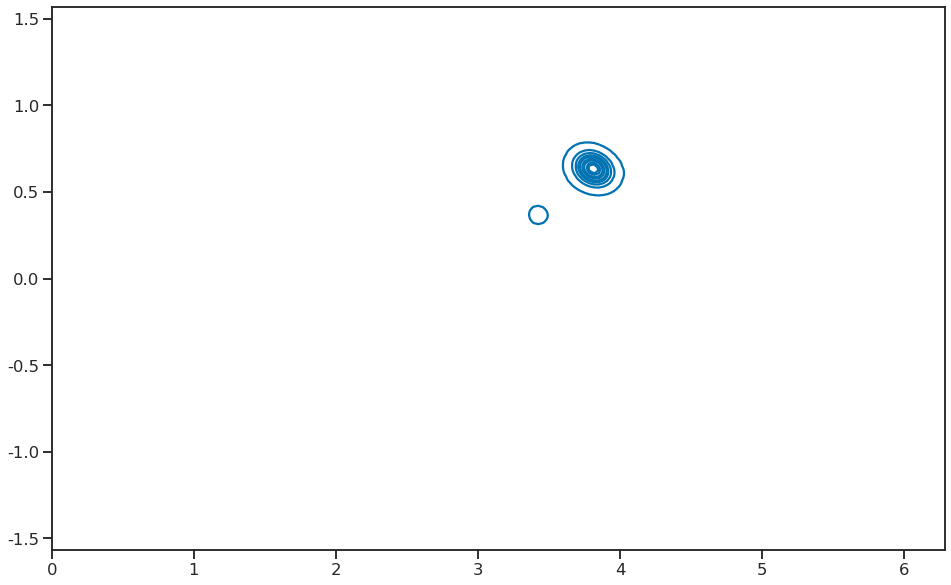

In [7]:
sns.kdeplot(x=ra,y=dec)
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi/2,np.pi/2)

/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

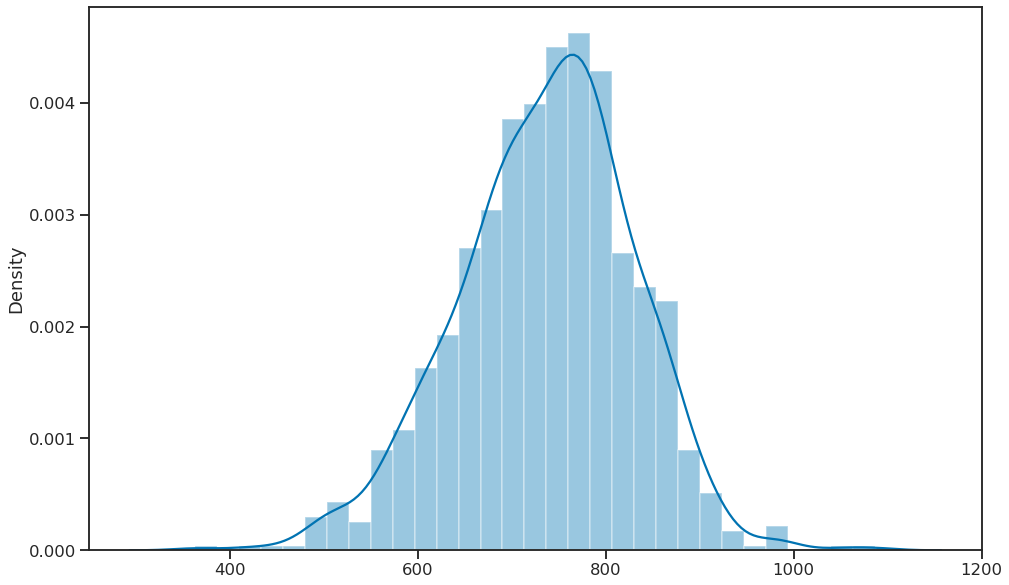

In [8]:
sns.distplot(dL)

<AxesSubplot:>

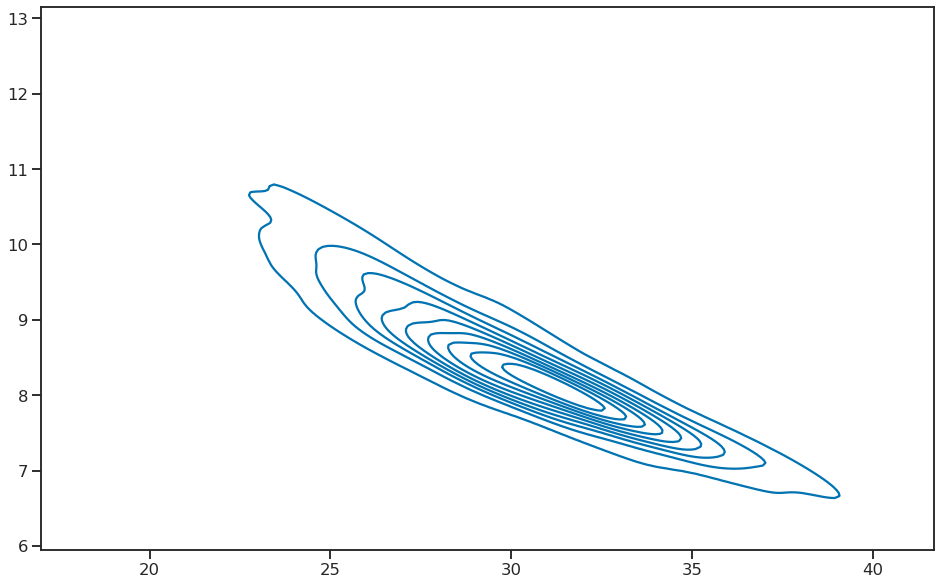

In [9]:
sns.kdeplot(x=m1det/(1+z_of_dL(dL,H0Planck)),y=m2det/(1+z_of_dL(dL,H0Planck)))


In [10]:
import gc

gc.collect()

4102

12288


100%|██████████| 12288/12288 [00:00<00:00, 374953.49it/s]


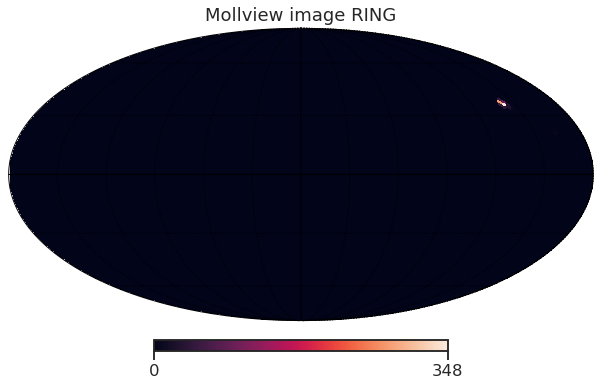

In [11]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)

print(npix)
samples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-dec,ra)

m = []
ids = []
for pix in tqdm(range(npix)):
    id = np.where(samples_ind == pix)[0]
    ids.append(id)   
    m.append(len(id))

m = np.asarray(m)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [12]:
pixgrid = jnp.arange(npix)
pixgrid = pixgrid[m>-1]
pixgrid.shape

samples_index = []
for pix in pixgrid:
    samples_index.append(ids[pix])

len(samples_index)

12288

In [13]:
samples_mask = []
for pix in pixgrid:
    mask = jnp.ones(m1det.shape,dtype=bool)
    mask = jnp.where((samples_ind == pix), mask, False)
    samples_mask.append(mask)

samples_mask = jnp.array(samples_mask)

samples_mask.shape

(12288, 1000)

56000000
(153663,)


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

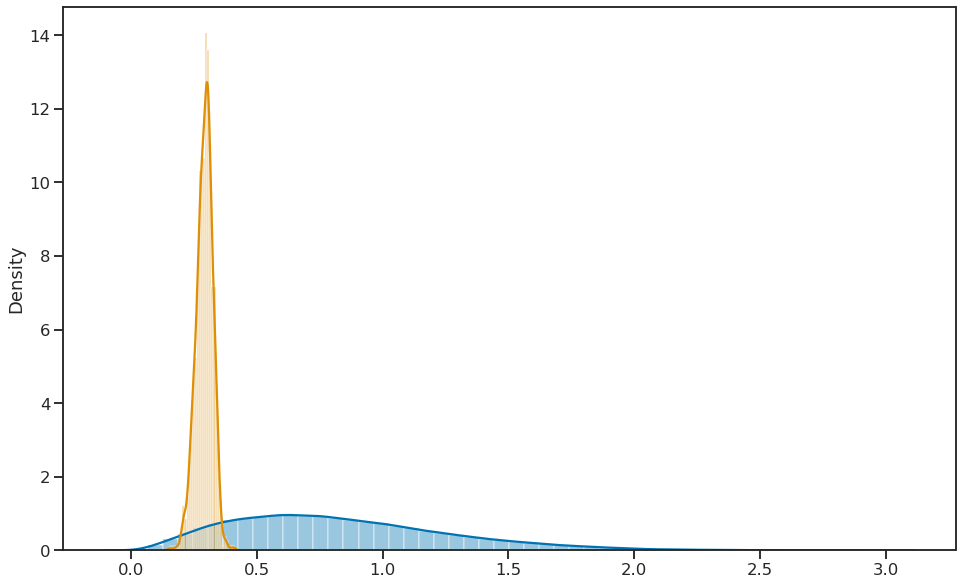

In [14]:
with h5py.File('O3-selected-sky.h5', 'r') as inp:
    Ndraw = inp.attrs['N_gen']
    rasels = np.array(inp['ra'])
    decsels = np.array(inp['dec'])
    m1detsels = np.array(inp['m1det'])
    m2detsels = np.array(inp['m2det'])
    dLsels = (np.array(inp['dl'])*u.Gpc).to(u.Mpc).value
    p_draw = np.array(inp['wt'])

nsel = int(len(m1detsels))
f = float(nsel)/float(len(m1detsels))
choose = np.random.choice(m1detsels.shape[0], replace=False, size=nsel)
Ndraw = int(round(f*Ndraw))

rasels = jnp.array(rasels[choose])
decsels = jnp.array(decsels[choose])
m1detsels = jnp.array(m1detsels[choose])
m2detsels = jnp.array(m2detsels[choose])
dLsels = jnp.array(dLsels[choose])
p_draw = jnp.array(p_draw[choose])

print(Ndraw)
print(p_draw.shape)
z_of_dL(dLsels,140,0.4).max()

sns.distplot(z_of_dL(dLsels,140,0.4))
sns.distplot(z_of_dL(dL,140,0.4))

100%|██████████| 12288/12288 [00:05<00:00, 2397.84it/s]


(12288, 153663)

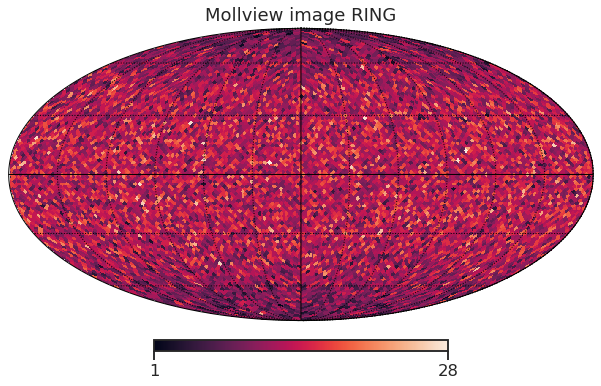

In [15]:
selsamples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-decsels,rasels)

m = []
for pix in tqdm(range(npix)):
    id = np.where(selsamples_ind == pix)[0]
    m.append(len(id))

m = np.asarray(m)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

selsamples_mask = []
for pix in tqdm(pixgrid):
    mask = jnp.ones(m1detsels.shape,dtype=bool)
    mask = jnp.where((selsamples_ind == pix), mask, False)
    selsamples_mask.append(mask)

selsamples_mask = jnp.array(selsamples_mask)

selsamples_mask.shape


In [16]:
del m
del ids
del mask
gc.collect()

6048

In [17]:
from jaxinterp2d import interp2d, CartesianGrid

limits = [(0, npix), (Om0grid[0], Om0grid[-1]), (deltagrid[0], deltagrid[-1])]
grid = CartesianGrid(limits, fs, mode='nearest')

@jit
def completeness_fraction(H0,Om0,n0,delta,pix):
    return grid(pix,Om0,delta)*(n0fid/n0)*(H0/H0Planck)**3

In [18]:
from jaxinterp2d import interp2d

vals = jnp.asarray(vals)
pixgrids = jnp.arange(npix)
vv = vals.reshape(len(pixgrids),len(zgrid))

@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(z,H0Planck,Om0)*(1+z)**(gamma-1)
    return dV/jnp.trapz(dV,z)

@jit
def PriorUniverse(z,pix,H0,Om0,n0,delta,gamma):
    f = completeness_fraction(H0,Om0,n0,delta,pix)
    prob = (f*interp2d(pix,zgrid,pixgrids,zgrid,vv) + (1-f)*dV_of_z_normed(zgrid,Om0,gamma))#*(1+zgrid)**(gamma-1)
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.interp(z,zgrid,prob)

@jit
def PriorUniverse_TEST(z,pix,H0,Om0,n0,delta,gamma):
    f = 1
    pvol = dV_of_z_normed(zgrid,Om0,1)
    pcat = interp2d(pix,zgrid,pixgrids,zgrid,vv)*pvol
    pcat = pcat/jnp.trapz(pcat,zgrid)
    pcat = jnp.where(~jnp.isnan(pcat), pcat, 0)
    prob = (f*pcat + (1-f)*pvol)*(1+zgrid)**(gamma-1)
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.interp(z,zgrid,prob)

@jit
def PriorUniverse_TEST2(z,pix,H0,Om0,n0,delta,gamma):
    f = completeness_fraction(H0,Om0,n0,delta,pix)
    dvdz = dV_of_z_normed(zgrid,Om0,1)

    pcat = interp2d(pix,zgrid,pixgrids,zgrid,vv)*dvdz*(1+zgrid)**(delta-1)
    pcat = pcat/jnp.trapz(pcat,zgrid)
    pcat = jnp.where(~jnp.isnan(pcat), pcat, 0)

    pvol = dvdz*(1+zgrid)**(gamma-1)
    pvol = pvol/jnp.trapz(pvol,zgrid)
    prob = f*pcat + (1-f)*pvol
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.interp(z,zgrid,prob)

@jit
def PriorUniverse_TEST3(z,pix,H0,Om0,n0,delta,gamma):
    #pvol = dV_of_z_normed(zgrid,Om0,1)
    pcat = interp2d(pix,zgrid,pixgrids,zgrid,vv)*(1+zgrid)**(gamma-1)*dV_of_z_normed(zgrid,Om0,1)
    pcat = pcat/jnp.trapz(pcat,zgrid)
    prob = jnp.where(~jnp.isnan(pcat), pcat, 0)
    return jnp.interp(z,zgrid,prob)

PriorUniverse_vmap = jit(vmap(PriorUniverse_TEST3, in_axes=(None,0,None,None,None,None,None), out_axes=0))

In [19]:
from jax.scipy.stats import norm

mass = jnp.exp(jnp.linspace(jnp.log(1), jnp.log(100), 500))
mass_ratio =  jnp.linspace(0, 1, 500)
'''
@jit
def logpm1(m1,m_min,m_max,alpha,dm_min,dm_max):
    pm1s = mass**(-alpha)*norm.cdf(jnp.log(mass),loc=jnp.log(m_min), scale=dm_min)*(1-norm.cdf(jnp.log(mass),loc=jnp.log(m_max), scale=dm_max))
    cm1s = jnp.trapz(pm1s,mass)
    pm1s = pm1s/cm1s
    return jnp.log(jnp.interp(m1,mass,pm1s))

@jit
def logpm2(m2,m_min,m_max,beta,dm_min,dm_max):
    pm2s = mass**beta*norm.cdf(jnp.log(mass),loc=jnp.log(m_min), scale=dm_min)*(1-norm.cdf(jnp.log(mass),loc=jnp.log(m_max), scale=dm_max))
    cm2s = jnp.trapz(pm2s,mass)
    pm2s = pm2s/cm2s
    return jnp.log(jnp.interp(m2,mass,pm2s))

@jit
def logpm1m2(m1,m2,m_min,m_max,alpha,beta):
    m1_norm = (1-alpha)/(m_max**(1-alpha) - m_min**(1-alpha))
    m2_norm = (1+beta)/(m1**(1+beta) - m_min**(1+beta))
    
    log_pm1 = -alpha*jnp.log(m1) + jnp.log(m1_norm)
    log_pm2 = beta*jnp.log(m2) + jnp.log(m2_norm)
    return jnp.where((m2 < m1) & (m_min < m2) & (m1 < m_max), log_pm1 + log_pm2, -jnp.inf)
'''
@jit
def logpm1q_nopeak(m1,m2,m_min,m_max,alpha,beta):

    pm1_pl = mass**(-alpha)
    pm1_pl = pm1_pl/jnp.trapz(pm1_pl,mass)
    
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapz(pq,mass_ratio)

    log_pm1 = jnp.log(jnp.interp(m1,mass,pm1_pl))
    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return jnp.where((m2 < m1) & (m_min < m2) & (m1 < m_max), log_pm1 + log_pq, -jnp.inf)    

@jit
def logpm1q(m1,m2,m_min,m_max,alpha,beta,mu,sigma,f):

    pm1_pl = mass**(-alpha)
    pm1_pl = pm1_pl/jnp.trapz(pm1_pl,mass)

    pm1_pp = jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1_pp = pm1_pp/jnp.trapz(pm1_pp,mass)

    pm1 = f*pm1_pp + (1-f)*pm1_pl
    
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapz(pq,mass_ratio)

    log_pm1 = jnp.log(jnp.interp(m1,mass,pm1))
    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return jnp.where((m2 < m1) & (m_min < m2) & (m1 < m_max), log_pm1 + log_pq, -jnp.inf)

In [20]:
Tobs_O1 = 51.5/365.25
Tobs_O2 = 118.0/365.25
#Tobs_O3 = 1

Tobs = Tobs_O1 + Tobs_O2# + Tobs_O3
@jit
def log_p_pop_pl(m1,m2,z,s1z,s2z,m_min,m_max,alpha,beta):

    log_dNdm1dm2 = logpm1q_nopeak(m1,m2,m_min,m_max,alpha,beta)
    log_p_sz = np.log(0.25) # 1/2 for each spin dimension

    return log_p_sz + log_dNdm1dm2

@jit
def log_p_pop_pl_p(m1,m2,z,s1z,s2z,m_min,m_max,alpha,beta,mu,sigma,f):

    log_dNdm1m2 = logpm1q(m1,m2,m_min,m_max,alpha,beta,mu,sigma,f)
    log_p_sz = np.log(0.25) # 1/2 for each spin dimension

    return log_p_sz + log_dNdm1m2

@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [21]:
GWTC1=True
if GWTC1:
    @jit
    def log_likelihood(H0=H0Planck, Om0=Om0Planck, log10n0=np.log10(n0fid), delta=3.0, alpha=2.7, beta=0, m_max=50, m_min=5, gamma=0):
        n0 = 10**log10n0
        zsels = z_of_dL(dLsels, H0, Om0)
        m1sels = m1detsels/(1+zsels)
        m2sels = m2detsels/(1+zsels)

        log_det_weights = log_p_pop_pl(m1sels,m2sels,zsels,s1z=0.,s2z=0.,
                                      alpha=alpha,beta=beta,m_max=m_max,
                                      m_min=m_min) - jnp.log(ddL_of_z(zsels,dLsels,H0, Om0))

        log_det_weights += - jnp.log(p_draw) - 2*jnp.log1p(zsels) - jnp.log(m1sels) + jnp.log(PriorUniverse_vmap(zsels,pixgrid,H0,Om0,n0,delta,gamma))# - jnp.log(jnp.cos(decsels)/4*np.pi)

        log_det_weights = jnp.where(~selsamples_mask,log_det_weights,-jnp.inf)
        log_det_weights = logsumexp(log_det_weights,axis=0)

        log_mu = logsumexp(log_det_weights) - jnp.log(Ndraw) 
        log_s2 = logsumexp(2*log_det_weights) - 2.0*jnp.log(Ndraw)
        log_sigma2 = logdiffexp(log_s2, 2.0*log_mu - jnp.log(Ndraw))
        Neff = jnp.exp(2.0*log_mu - log_sigma2)

        ll = -jnp.inf
        ll = jnp.where((Neff <= 4 * nEvents), ll, 0)
        ll += -nEvents*log_mu + nEvents*(3 + nEvents)/(2*Neff)

        z = z_of_dL(dL, H0, Om0)
        m1 = m1det/(1+z)
        m2 = m2det/(1+z)

        log_weights = log_p_pop_pl(m1,m2,z,s1z=0.,s2z=0.,
                                  alpha=alpha,beta=beta,m_max=m_max,
                                  m_min=m_min)

        log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - 2*jnp.log(dL) - 2*jnp.log1p(z) - jnp.log(m1) + jnp.log(PriorUniverse_vmap(z,pixgrid,H0,Om0,n0,delta,gamma))

        log_weights = jnp.where(~samples_mask,log_weights,-jnp.inf)
        log_weights = logsumexp(log_weights,axis=0)

        log_weights = log_weights.reshape((nEvents,nsamp))
        ll += jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))

        return ll
else:
    @jit
    def log_likelihood(H0=H0Planck, Om0=Om0Planck, log10n0=np.log10(n0fid), delta=0.0, alpha=2.7, beta=1.3, m_max=86, m_min=5, gamma=2.7,mu=33,sigma=6,log10f=np.log10(0.1)):
        f = 10**log10f
        n0 = 10**log10n0
        zsels = z_of_dL(dLsels, H0, Om0)
        m1sels = m1detsels/(1+zsels)
        m2sels = m2detsels/(1+zsels)

        log_det_weights = log_p_pop_pl_p(m1sels,m2sels,zsels,s1z=0.,s2z=0.,
                                      alpha=alpha,beta=beta,m_max=m_max,
                                      m_min=m_min,mu=mu,sigma=sigma,f=f) - jnp.log(ddL_of_z(zsels,dLsels,H0, Om0))

        log_det_weights += - jnp.log(p_draw) - 2*jnp.log1p(zsels) - jnp.log(m1sels) + jnp.log(PriorUniverse_vmap(zsels,pixgrid,H0,Om0,n0,delta,gamma))

        log_det_weights = jnp.where(~selsamples_mask,log_det_weights,-jnp.inf)
        log_det_weights = logsumexp(log_det_weights,axis=0)

        log_mu = logsumexp(log_det_weights) - jnp.log(Ndraw) 
        log_s2 = logsumexp(2*log_det_weights) - 2.0*jnp.log(Ndraw)
        log_sigma2 = logdiffexp(log_s2, 2.0*log_mu - jnp.log(Ndraw))
        Neff = jnp.exp(2.0*log_mu - log_sigma2)

        ll = -jnp.inf
        ll = jnp.where((Neff <= 4 * nEvents), ll, 0)
        ll += -nEvents*log_mu + nEvents*(3 + nEvents)/(2*Neff)

        z = z_of_dL(dL, H0, Om0)
        m1 = m1det/(1+z)
        m2 = m2det/(1+z)

        log_weights = log_p_pop_pl_p(m1,m2,z,s1z=0.,s2z=0.,
                                  alpha=alpha,beta=beta,m_max=m_max,
                                  m_min=m_min,mu=mu,sigma=sigma,f=f)

        log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - 2*jnp.log(dL) - 2*jnp.log1p(z) - jnp.log(m1) + jnp.log(PriorUniverse_vmap(z,pixgrid,H0,Om0,n0,delta,gamma))

        log_weights = jnp.where(~samples_mask,log_weights,-jnp.inf)
        log_weights = logsumexp(log_weights,axis=0)

        log_weights = log_weights.reshape((nEvents,nsamp))
        ll += jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))

        return ll

%time log_likelihood().block_until_ready()  # measure JAX compilation time
%timeit log_likelihood().block_until_ready()  # measure JAX runtime
#log_likelihood(H0=H0Planck, Om0=Om0Planck, log10n0=np.log10(n0fid), delta=0, alpha=2.7, beta=0, m_max=42, m_min=5, gamma=0)

CPU times: user 48.3 s, sys: 6.28 s, total: 54.6 s
Wall time: 49.6 s
71.8 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


20.0 -23.485265113351836
20.603015075376884 -23.47372816769036
21.20603015075377 -23.47700729560198
21.809045226130657 -23.498106951449316
22.412060301507537 -23.528249135264396
23.015075376884425 -23.564338247597803
23.618090452261306 -23.5969854286772
24.22110552763819 -23.621859044889682
24.824120603015075 -23.629348545256505
25.427135678391963 -23.61893252184347
26.030150753768844 -23.58966563054294
26.633165829145728 -23.54321162358562
27.236180904522612 -23.48233499632098
27.8391959798995 -23.409727889064435
28.44221105527638 -23.332082503871344
29.045226130653266 -23.252869332354717
29.64824120603015 -23.17047400096983
30.251256281407034 -23.09068859482239
30.85427135678392 -23.016451241852213
31.457286432160807 -22.954470356121718
32.06030150753769 -22.903588870826425
32.663316582914575 -22.865649208955006
33.266331658291456 -22.837636770118344
33.869346733668344 -22.818871543637883
34.472361809045225 -22.805890336102905
35.07537688442211 -22.800330736911363
35.678391959799 -22

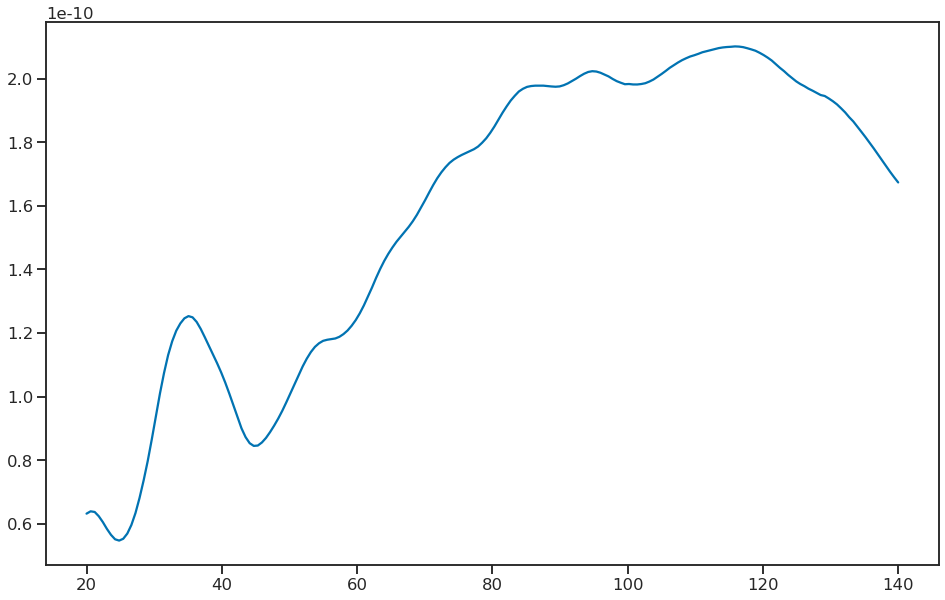

In [22]:
H0grid= jnp.linspace(20,140,200)
ll = []
for h0 in H0grid:
    l = log_likelihood(H0=h0)
    print(h0,l)
    ll.append(l)
ll = np.asarray(ll)
plt.plot(H0grid,np.exp(ll))

In [23]:
if GWTC1:
    with PriorChain() as prior_chain:
        UniformPrior('H0', 20, 140)
        #UniformPrior('Om0', Om0grid[0], Om0grid[-1])
        UniformPrior('log10n0', -5.0, 1.0)
        #UniformPrior('delta', 0, 3)
        #UniformPrior('alpha', -4, 8)
        #UniformPrior('beta', -4, 8)
        #UniformPrior('m_max', 20, 100)
        #UniformPrior('m_min', 1, 15)
        #UniformPrior('gamma', -25, 25)

else:
    with PriorChain() as prior_chain:
        UniformPrior('H0', 20, 140)
        UniformPrior('Om0', Om0grid[0], Om0grid[-1])
        UniformPrior('log10n0', -5.0, 1.0)
        UniformPrior('delta', 0, 3)
        UniformPrior('alpha', -4, 8)
        UniformPrior('beta', -4, 8)
        UniformPrior('m_max', 50, 100)
        UniformPrior('m_min', 1, 15)
        UniformPrior('gamma', -25, 25)
        UniformPrior('mu', 20, 40)
        UniformPrior('sigma', 0.1, 1)
        UniformPrior('log10f', -5.0, 0.0)

ns = NestedSampler(log_likelihood, prior_chain, sampler_kwargs=dict(num_slices=prior_chain.U_ndims))#prior_chain.U_ndims, 

key = random.PRNGKey(42)

results = jit(ns)(key, num_live_points=1000)

/global/homes/w/wballard/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/jaxns/likelihood_samplers/parallel_slice_sampling.py:189: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  next_reservoir = tree_map(lambda operand, update: dynamic_update_slice(operand,
/global/homes/w/wballard/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/jaxns/likelihood_samplers/parallel_slice_sampling.py:303: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return tree_map(lambda a, b: jnp.where(cond, a, b), a_tree, b_tree)
/global/homes/w/wballard/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/jaxns/nested_sampler/static.py:18: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  next_point_X = tree_map(lambda y: y[idx_min_thread], state.

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 7037
# samples: 1185
# likelihood evals / sample: 5.9
--------
logZ=-22.583 +- 0.021
H=1.1
ESS=258


/global/homes/w/wballard/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/jaxns/utils.py:326: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  max_like_points = tree_map(lambda x: x[max_like_idx], results.samples)
/global/homes/w/wballard/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/jaxns/utils.py:255: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  map_points = tree_map(lambda x: x[map_idx], results.samples)


--------
H0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
H0: 86.0 +- 33.0 | 34.0 / 89.0 / 128.0 | 139.0 | 116.0
--------
log10n0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log10n0: -2.1 +- 1.8 | -4.5 / -2.1 / 0.2 | -4.2 | -3.8
--------


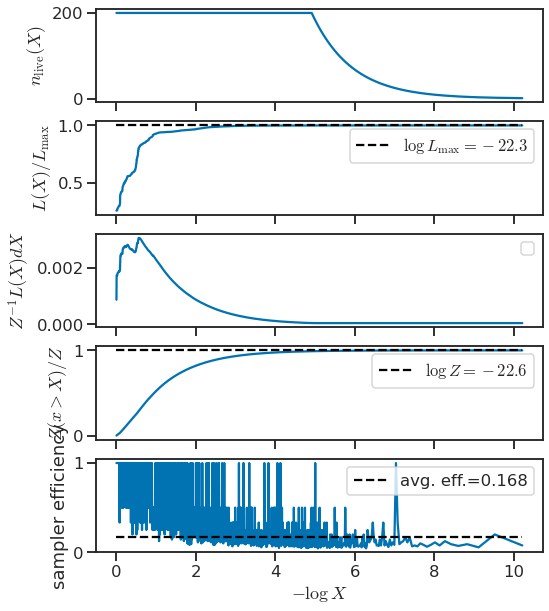

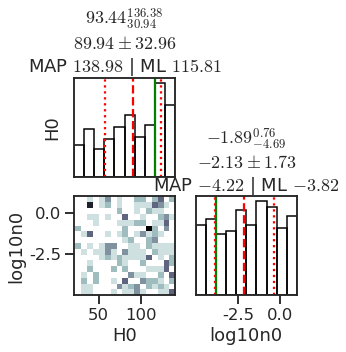

In [24]:
 # We can use the summary utility to display results
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

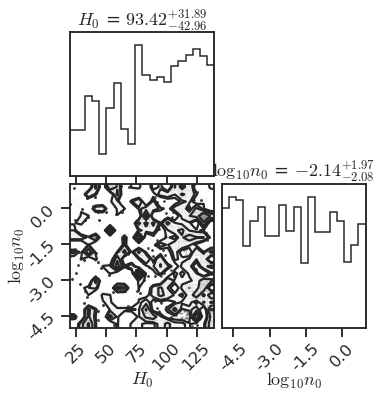

In [25]:
import corner

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=100*int(results.ESS))

labels = [r'$H_0$',#r'$\Omega_m$',
          r'$\log_{10}n_0$']

fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, show_titles=True)
plt.show()


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

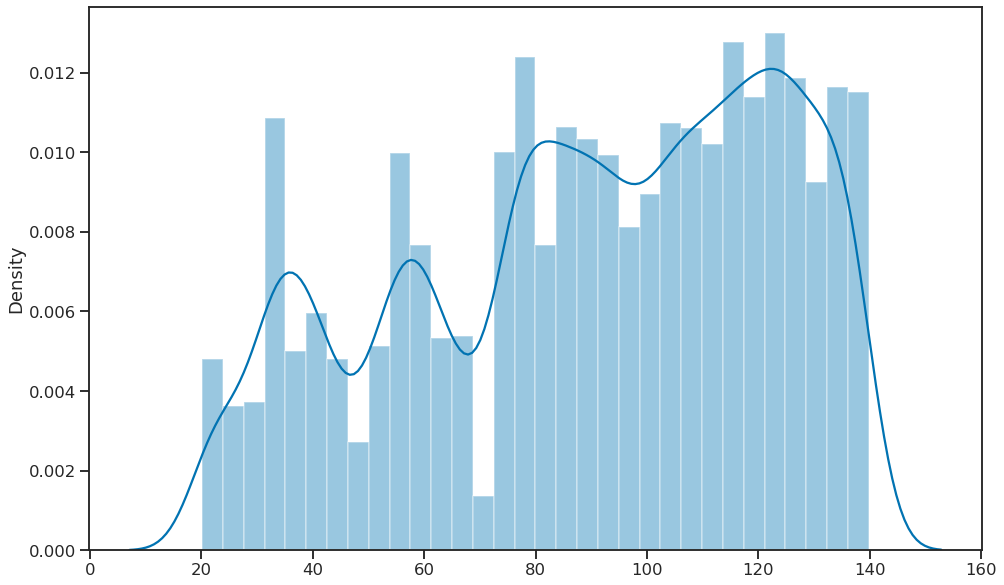

In [26]:
sns.distplot(samples['H0'])

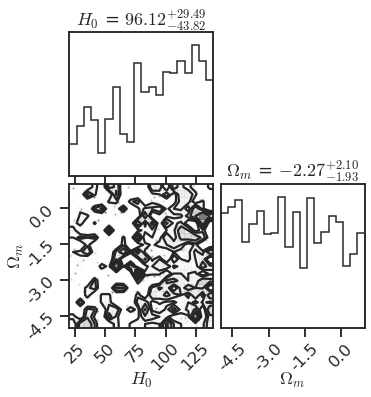

In [27]:
import corner

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=10*int(results.ESS))

if GWTC1:
    labels = [r'$H_0$',r'$\Omega_m$',r'$\alpha$',r'$\beta$',r'$\delta$',r'$\gamma$',
              r'$\log_{10}n_0$', r'$m_{\rm max}$',r'$m_{\rm min}$']
else:
    labels = [r'$H_0$',r'$\Omega_m$',r'$\alpha$',r'$\beta$',r'$\delta$',r'$\gamma$',
              r'$\log_{10}f$',r'$\log_{10}n_0$', r'$m_{\rm max}$',r'$m_{\rm min}$',r'$\mu$',r'$\sigma$']

fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, show_titles=True)
plt.show()


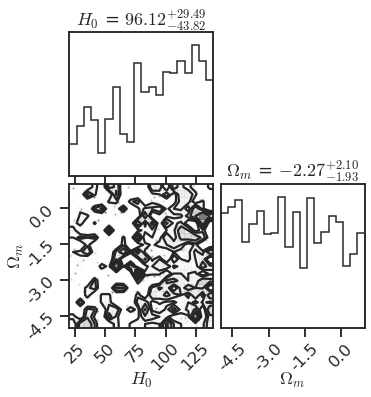

In [28]:
import corner

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=10*int(results.ESS))

if GWTC1:
    labels = [r'$H_0$',r'$\Omega_m$',r'$\alpha$',r'$\beta$',r'$\delta$',r'$\gamma$',
              r'$\log_{10}n_0$', r'$m_{\rm max}$',r'$m_{\rm min}$']
else:
    labels = [r'$H_0$',r'$\Omega_m$',r'$\alpha$',r'$\beta$',r'$\delta$',r'$\gamma$',
              r'$\log_{10}f$',r'$\log_{10}n_0$', r'$m_{\rm max}$',r'$m_{\rm min}$',r'$\mu$',r'$\sigma$']

fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, show_titles=True)
plt.show()
